In [70]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')



import argparse
import time

import gzip
import os
import numpy as np
import six
from six.moves.urllib import request

import chainer
from chainer import computational_graph
from chainer import cuda
import chainer.links as L
from chainer import optimizers
from chainer import serializers

import chainer
import chainer.functions as F
import chainer.links as L

In [71]:
parent = 'http://yann.lecun.com/exdb/mnist'
train_images = 'train-images-idx3-ubyte.gz'
train_labels = 'train-labels-idx1-ubyte.gz'
test_images = 't10k-images-idx3-ubyte.gz'
test_labels = 't10k-labels-idx1-ubyte.gz'
num_train = 60000
num_test = 10000
dim = 784

In [72]:
def load_mnist(images, labels, num):
    data = np.zeros(num * dim, dtype=np.uint8).reshape((num, dim))
    target = np.zeros(num, dtype=np.uint8).reshape((num, ))

    with gzip.open(images, 'rb') as f_images,\
            gzip.open(labels, 'rb') as f_labels:
        f_images.read(16)
        f_labels.read(8)
        for i in six.moves.range(num):
            target[i] = ord(f_labels.read(1))
            for j in six.moves.range(dim):
                data[i, j] = ord(f_images.read(1))

    return data, target

In [73]:
def download_mnist_data():
    print('Downloading {:s}...'.format(train_images))
    request.urlretrieve('{:s}/{:s}'.format(parent, train_images), train_images)
    print('Done')
    print('Downloading {:s}...'.format(train_labels))
    request.urlretrieve('{:s}/{:s}'.format(parent, train_labels), train_labels)
    print('Done')
    print('Downloading {:s}...'.format(test_images))
    request.urlretrieve('{:s}/{:s}'.format(parent, test_images), test_images)
    print('Done')
    print('Downloading {:s}...'.format(test_labels))
    request.urlretrieve('{:s}/{:s}'.format(parent, test_labels), test_labels)
    print('Done')

    print('Converting training data...')
    data_train, target_train = load_mnist(train_images, train_labels,
                                          num_train)
    print('Done')
    print('Converting test data...')
    data_test, target_test = load_mnist(test_images, test_labels, num_test)
    mnist = {'data': np.append(data_train, data_test, axis=0),
             'target': np.append(target_train, target_test, axis=0)}

    print('Done')
    print('Save output...')
    with open('mnist.pkl', 'wb') as output:
        six.moves.cPickle.dump(mnist, output, -1)
    print('Done')
    print('Convert completed')

In [74]:
def load_mnist_data():
    if not os.path.exists('mnist.pkl'):
        download_mnist_data()
    with open('mnist.pkl', 'rb') as mnist_pickle:
        mnist = six.moves.cPickle.load(mnist_pickle)
    return mnist


In [75]:
class MnistMLP(chainer.Chain):

    """An example of multi-layer perceptron for MNIST dataset.

    This is a very simple implementation of an MLP. You can modify this code to
    build your own neural net.

    """
    def __init__(self, n_in, n_units, n_out):
        super(MnistMLP, self).__init__(
            l1=L.Linear(n_in, n_units),
            l2=L.Linear(n_units, n_units),
            l3=L.Linear(n_units, n_out),
        )

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

In [76]:
class MnistMLPParallel(chainer.Chain):

    """An example of model-parallel MLP.

    This chain combines four small MLPs on two different devices.

    """
    def __init__(self, n_in, n_units, n_out):
        super(MnistMLPParallel, self).__init__(
            first0=MnistMLP(n_in, n_units // 2, n_units).to_gpu(0),
            first1=MnistMLP(n_in, n_units // 2, n_units).to_gpu(1),
            second0=MnistMLP(n_units, n_units // 2, n_out).to_gpu(0),
            second1=MnistMLP(n_units, n_units // 2, n_out).to_gpu(1),
        )

    def __call__(self, x):
        # assume x is on GPU 0
        x1 = F.copy(x, 1)

        z0 = self.first0(x)
        z1 = self.first1(x1)

        # sync
        h0 = z0 + F.copy(z1, 0)
        h1 = z1 + F.copy(z0, 1)

        y0 = self.second0(F.relu(h0))
        y1 = self.second1(F.relu(h1))

        # sync
        y = y0 + F.copy(y1, 0)
        return y

In [77]:
# 確率的勾配降下法で学習させる際の１回分のバッチサイズ
batchsize = 100
# 学習の繰り返し回数
n_epoch   = 20
# 中間層の数
n_units   = 1000

# MNISTの手書き数字データのダウンロード
# #HOME/scikit_learn_data/mldata/mnist-original.mat にキャッシュされる
print('fetch MNIST dataset')
print('load MNIST dataset')
mnist = load_mnist_data()
# mnist.data : 70,000件の784次元ベクトルデータ
mnist['data'] = mnist['data'].astype(np.float32)
mnist['data'] /= 255 # 0-1のデータに変換
# mnist.target : 正解データ（教師データ）
mnist['target'] = mnist['target'].astype(np.int32)

fetch MNIST dataset
load MNIST dataset


In [78]:
# 学習用データを N個、検証用データを残りの個数と設定
N = 60000
x_train, x_test = np.split(mnist.data,   [N])
y_train, y_test = np.split(mnist.target, [N])
N_test = y_test.size

# Prepare multi-layer perceptron model
# 多層パーセプトロンモデルの設定
# 入力 784次元、出力 10次元
model = FunctionSet(l1=F.Linear(784, n_units),
                    l2=F.Linear(n_units, n_units),
                    l3=F.Linear(n_units, 10))

# Neural net architecture
# ニューラルネットの構造
def forward(x_data, y_data, train=True):
    x, t = Variable(x_data), Variable(y_data)
    h1 = F.dropout(F.relu(model.l1(x)),  train=train)
    h2 = F.dropout(F.relu(model.l2(h1)), train=train)
    y  = model.l3(h2)
    # 多クラス分類なので誤差関数としてソフトマックス関数の
    # 交差エントロピー関数を用いて、誤差を導出
    return F.softmax_cross_entropy(y, t), F.accuracy(y, t)

# Setup optimizer
optimizer = optimizers.Adam()
optimizer.setup(model)

AttributeError: 'dict' object has no attribute 'data'

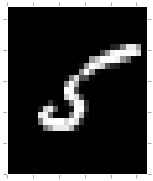

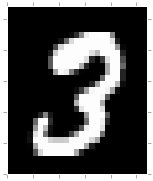

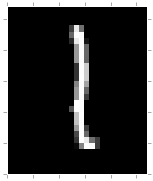

In [79]:
# 手書き数字データを描画する関数
def draw_digit(data):
    size = 28
    plt.figure(figsize=(2.5, 3))

    X, Y = np.meshgrid(range(size),range(size))
    Z = data.reshape(size,size)   # convert from vector to 28x28 matrix
    Z = Z[::-1,:]             # flip vertical
    plt.xlim(0,27)
    plt.ylim(0,27)
    plt.pcolor(X, Y, Z)
    plt.gray()
    plt.tick_params(labelbottom="off")
    plt.tick_params(labelleft="off")
    plt.show()

draw_digit(mnist['data'][11])
draw_digit(mnist['data'][12345])
draw_digit(mnist['data'][33456])


In [81]:
# 学習用データを N個、検証用データを残りの個数と設定
N = 60000
gpu = -1
x_train, x_test = np.split(mnist['data'],   [N])
y_train, y_test = np.split(mnist['target'], [N])
N_test = y_test.size

# Prepare multi-layer perceptron model
model = L.Classifier(MnistMLP(784, n_units, 10))
if gpu >= 0:
    cuda.get_device(gpu).use()
    model.to_gpu()
xp = np if gpu < 0 else cuda.cupy

# Setup optimizer
optimizer = optimizers.Adam()
optimizer.setup(model)


In [82]:
# Learning loop
for epoch in six.moves.range(1, n_epoch + 1):
    print('epoch', epoch)

    # training
    perm = np.random.permutation(N)
    sum_accuracy = 0
    sum_loss = 0
    start = time.time()
    for i in six.moves.range(0, N, batchsize):
        x = chainer.Variable(xp.asarray(x_train[perm[i:i + batchsize]]))
        t = chainer.Variable(xp.asarray(y_train[perm[i:i + batchsize]]))

        # Pass the loss function (Classifier defines it) and its arguments
        optimizer.update(model, x, t)

        if epoch == 1 and i == 0:
            with open('graph.dot', 'w') as o:
                variable_style = {'shape': 'octagon', 'fillcolor': '#E0E0E0',
                                  'style': 'filled'}
                function_style = {'shape': 'record', 'fillcolor': '#6495ED',
                                  'style': 'filled'}
                g = computational_graph.build_computational_graph(
                    (model.loss, ),
                    variable_style=variable_style,
                    function_style=function_style)
                o.write(g.dump())
            print('graph generated')

        sum_loss += float(model.loss.data) * len(t.data)
        sum_accuracy += float(model.accuracy.data) * len(t.data)
    end = time.time()
    elapsed_time = end - start
    throughput = N / elapsed_time
    print('train mean loss={}, accuracy={}, throughput={} images/sec'.format(
        sum_loss / N, sum_accuracy / N, throughput))

    # evaluation
    sum_accuracy = 0
    sum_loss = 0
    for i in six.moves.range(0, N_test, batchsize):
        x = chainer.Variable(xp.asarray(x_test[i:i + batchsize]),
                             volatile='on')
        t = chainer.Variable(xp.asarray(y_test[i:i + batchsize]),
                             volatile='on')
        loss = model(x, t)
        sum_loss += float(loss.data) * len(t.data)
        sum_accuracy += float(model.accuracy.data) * len(t.data)

    print('test  mean loss={}, accuracy={}'.format(
        sum_loss / N_test, sum_accuracy / N_test))

epoch 1
graph generated
train mean loss=72.77834922770658, accuracy=0.548199998922646, throughput=821.9231018705136 images/sec
test  mean loss=219.76288055419923, accuracy=0.50469999730587
epoch 2
train mean loss=323.64375639279683, accuracy=0.5700666668762764, throughput=991.7653031961943 images/sec
test  mean loss=361.8062232971191, accuracy=0.5763999950885773
epoch 3
train mean loss=886.6121348063151, accuracy=0.5786999992032846, throughput=1416.5538278092422 images/sec
test  mean loss=1627.0319134521485, accuracy=0.44789999663829805
epoch 4
train mean loss=1411.1040188598633, accuracy=0.5954166663189729, throughput=1473.4830824416038 images/sec
test  mean loss=888.3568920898438, accuracy=0.6919000005722046
epoch 5
train mean loss=1560.757921702067, accuracy=0.6334499986966451, throughput=1499.472335891493 images/sec
test  mean loss=1180.1152792358398, accuracy=0.698100003004074
epoch 6
train mean loss=3162.0104974365236, accuracy=0.6203499992688497, throughput=1518.1738278961234 im

In [83]:
# Save the model and the optimizer
print('save the model')
serializers.save_npz('mlp.model', model)
print('save the optimizer')
serializers.save_npz('mlp.state', optimizer)

save the model
save the optimizer
